# to do
I do not think the misfit algorithm is working well. For real pyroclastic flow, it puts solutions too close to the station with highest displacement.  So rather than minimizing the normalized standard deviation, perhaps I minimize the absolute differences squared between real displacements and estimated displacements. Or the ratios of real to estimated? Perhaps I program in 3 misfit functions and see which is best. I possibly also need to do the iteration to smaller grid size to really refine locations.

# Amplitude Source Location (ASL)

## 1. Introduction

### 1.1 Review

In the previous tutorial, we estimated Reduced Displacement by assuming a source location, e.g. the summit of a volcano. But it would be better if we locate volcano-seismic signals, and then compute Reduced Displacement. Most volcano-seismic signals cannot be located using traditional differential travel-time techniques, because they lack identifiable phases (sources are quasi-continuous, so phases are arriving all the time). So what else can we do?

### 1.2 Motivation
In summer 1996, I was fortunate enough as a graduate student to be asked to assist the British Geological Survey in its monitoring of the Soufriere Hills Volcano, Montserrat. As part of "Team Seismic" at the Montserrat Volcano Observatory, our job was to provide 24-7 monitoring of the lava dome eruption, which had been continuous since October 1995. Crucially, this involved two-way radio communications with others working on the slopes of the volcano, and warning them of seismicity, especially pyroclastic flows [Add video here from Lauren's Journeys program]. 

I had the idea that we could use the RSAM data to locate seismicity continuously, on a map on a monitor in the Ops Room. I created a proof-of-concept, using the 60-s RSAM data (the 2.56-s RSAM data wasn't captured), and applying calibration constants. We'll replicate that here, but use DSAM data, which has already been instrument-corrected. For simplicity - and speed which was important for a real-time system - we ignore the vertical dimension (topography and station elevations ignored), and assume an isotropic, homogeneous half-space.

First, we will run a simulation, to demonstrate that our location technique works. Then we will compute locations for real DSAM data, and then for a known pyroclastic flow signal.

### 1.3 Setup

We need to import the following, to set things up.

In [ ]:
import os
import sys
import numpy as np
import time
import obspy
from obspy import read_inventory
sys.path.append('../lib')
import setup_paths
paths = setup_paths.paths
from SAM import DSAM


def montserrat_topo_map(show=False, zoom_level=0, inv=None, add_labels=False, centerlon=-62.177, centerlat=16.711, contour_interval=100, topo_color=True):
    #define etopo data file
    # topo_data = 'path_to_local_data_file'
    #topo_data = '@earth_relief_30s' #30 arc second global relief (SRTM15+V2.1 @ 1.0 km)
    # topo_data = '@earth_relief_15s' #15 arc second global relief (SRTM15+V2.1)
    topo_data = '@earth_relief_03s' #3 arc second global relief (SRTM3S)
    
    # define plot geographical range
    diffdeglat = 0.08/(2**zoom_level)
    diffdeglon = diffdeglat/np.cos(np.deg2rad(centerlat))http://localhost:8888/notebooks/src/30_ASL/00_locate_tremor.ipynb#
    minlon, maxlon = centerlon-diffdeglon, centerlon+diffdeglon  #-62.25, -62.13
    minlat, maxlat = centerlat-diffdeglat, centerlat+diffdeglat  # 16.66, 16.83
    print(minlon, maxlon, minlat, maxlat)
    
    # Visualization
    fig = pygmt.Figure()
    
    if topo_color:
        # make color pallets
        pygmt.makecpt(
            cmap='topo',
            series='-1300/1300/%d' % contour_interval,
            continuous=True
        )

        # plot high res topography
        fig.grdimage(
            grid=topo_data,
            region=[minlon, maxlon, minlat, maxlat],
            projection='M4i',
            shading=True,
            frame=True
            )
    
    # plot continents, shorelines, rivers, and borders
    fig.coast(
        region=[minlon, maxlon, minlat, maxlat],
        projection='M4i',
        shorelines=True,
        frame=True
        )
    
    # plot the topographic contour lines
    fig.grdcontour(
        grid=topo_data,
        interval=contour_interval,
        annotation="%d+f6p" % contour_interval,
        limit="-1300/1300", #to only display it below 
        pen="a0.15p"
        )
    
    if topo_color:
        fig.colorbar(
            frame='+l"Topography"',
        #     position="x11.5c/6.6c+w6c+jTC+v" #for vertical colorbar
            )

    
    if inv:
        seed_ids = inventory2seedids(inv, force_location_code='')
        #print(seed_ids)
        stalat = [inv.get_coordinates(seed_id)['latitude'] for seed_id in seed_ids]
        stalon = [inv.get_coordinates(seed_id)['longitude'] for seed_id in seed_ids]
        fig.plot(x=stalon, y=stalat, style="s0.4c", fill="dodgerblue4", pen='2p,blue')  
        
        if add_labels:
            #print('Adding station labels')
            for thislat, thislon, this_id in zip(stalat, stalon, seed_ids):
                net, sta, loc, chan = this_id.split('.')
                #print(thislat, thislon, net, sta, loc, chan)
                fig.text(x=thislon, y=thislat, text=sta, textfiles=None, \
                        font="blue",
                        justify="ML",
                        offset="0.2c/0c",)
    
    if show:
        fig.show();


    return fig

from ASL import montserrat_topo_map, Grid, ASL, simulate_DSAM

## 2. Synthetic testing

### 2.1 Map of Montserrat stations
We generate a map of seismic stations with a vertical-component sensor, operational (though not necessarily working properly) on July 12, 2003. This 13-station network provides good azimuthal coverage.

In [ ]:
invMVO = read_inventory(os.path.join(paths['RESPONSE_DIR'],'MV.xml'), format='stationxml')
startt = obspy.UTCDateTime(2003,7,12,23,0,0)
endt = obspy.UTCDateTime(2003,7,13,4,0,0)
invMVO = invMVO.select(starttime=startt, endtime=endt)
invMVO = invMVO.select(channel='*Z')
montserrat_topo_map(inv=invMVO, show=True, add_labels=True);

### 2.2 Define a grid of source locations and reduced displacement at those nodes

In [ ]:
sampling_interval = 60
synthetic_source = {}
N = 10
synthetic_source['lat'] = 16.69 + np.tile(np.arange(N)/200, N)
synthetic_source['lon'] = -62.20 + np.repeat(np.arange(N)/200, N)
synthetic_source['DR'] = np.ones(N*N) * 100.0 # 100 cm^2 everywhere
synthetic_source['t'] = [obspy.UTCDateTime(0) + t * sampling_interval for t in range(N*N)]
#print(synthetic_source)

surfaceWaveSpeed_kms = 1.5
peakf=8.0
Q=23
synthDSAMobj = simulate_DSAM(invMVO, synthetic_source, surfaceWaves=True, wavespeed_kms=surfaceWaveSpeed_kms, \
                             peakf=peakf, Q=Q, noise_level_percent=0.0)
synthDSAMobj.plot(metrics='mean')

### 2.3 Create grid with 100-m node spacing, 8 x 10 km 

In [ ]:
node_spacing_m = 100
grid_size_lat_m = 10000
grid_size_lon_m = 8000
nlat = int(grid_size_lat_m/node_spacing_m) + 1
nlon = int(grid_size_lon_m/node_spacing_m) + 1
gridobj = Grid(np.mean(synthetic_source['lat']), np.mean(synthetic_source['lon']), nlat, nlon, node_spacing_m)  
gridobj.plot(node_spacing_m = node_spacing_m)

### 2.4 Plot synthetic source locations, and DR time series (all equal=100 ${cm}^2$)

In [ ]:
aslobj = ASL(synthDSAMobj, 'mean', invMVO, gridobj)

aslobj.plot(synthetic_source, zoom_level=1, threshold_DR=1.0, scale=0.1)

### 2.5 Run location algorithm on synthetic source and plot resulting locations and DR time series

In [ ]:
aslobj.compute_grid_distances()

aslobj.compute_amplitude_corrections(surfaceWaves=True, wavespeed_kms=surfaceWaveSpeed_kms, Q=Q, fix_peakf=peakf)

time1 = time.time()
source = aslobj.locate()
time2 = time.time()
print(f'Location algorithm took {time2-time1} s')
aslobj.plot(source, zoom_level=1, scale=0.1, threshold_DR=0.0)

In [ ]:
time1 = time.time()
fast_source = aslobj.fast_locate()
time2 = time.time()
print(f'Vectorized location algorithm took {time2-time1} s')
aslobj.plot(fast_source, zoom_level=1, scale=0.1, threshold_DR=0.0)

## 3 Locating real DSAM data: July 12, 2003 collapse

Now we are confident in our ability to locate synthetic data correctly, and determine reduced displacement correctly, we will try to locate some real data. In this example, we use the 'VT' metric from the DSAM dataset. Recall that this is the mean amplitude of the signal (over 60-s time windows) after filtering between 4 and 18 Hz, rather than the 'mean' metric (or 'median', or 'rms' etc.) which are computed on signals filtered between 0.5 and 18 Hz. We do this because Jolly et al. (2002) determined that a 7-9 Hz bandpass was best for locating pyroclastic flows, and so the VT band is the one we have available that best matches this.

### 3.1 Read inventory and DSAM data. Plot DSAM data

In [ ]:
invMVO = read_inventory(os.path.join(paths['RESPONSE_DIR'],'MV.xml'), format='stationxml')
startt = obspy.UTCDateTime(2003,7,12,23,0,0)
endt = obspy.UTCDateTime(2003,7,13,4,0,0)
dsamObj = DSAM.read(startt, endt, SAM_DIR=paths['SAM_DIR'], sampling_interval=60, ext='pickle', \
                     trace_ids=['MV.MBGH..BHZ', 'MV.MBLG..SHZ', 'MV.MBRY..BHZ', 'MV.MBSS..SHZ', 'MV.MBWH..SHZ'])  

dsamObj.plot(metrics='VT')

### 3.2 Create dense grid (20-m node spacing) and plot

In [ ]:
source = {'lat':16.71111, 'lon':-62.17722}
node_spacing_m = 20
grid_size_lat_m = 10000
grid_size_lon_m = 8000
nlat = int(grid_size_lat_m/node_spacing_m) + 1
nlon = int(grid_size_lon_m/node_spacing_m) + 1
gridobj = Grid(source['lat'], source['lon'], nlat, nlon, node_spacing_m)  
gridobj.plot(node_spacing_m = node_spacing_m)

### 3.3 Create ASL object, compute combined eometrical spreading and inelatic attenuation corrections for each node

In [ ]:
Q = 23
surfaceWaveSpeed_kms = 1.5 # km/s
peakf = 8.0

aslobj = ASL(dsamObj, 'rms', invMVO, gridobj)

aslobj.compute_grid_distances()

aslobj.compute_amplitude_corrections(surfaceWaves=True, wavespeed_kms=surfaceWaveSpeed_kms, Q=Q, fix_peakf = peakf)

### 3.4 Run the amplitude location

In [ ]:
source = aslobj.fast_locate()

### 3.5 Plot sources and source reduced displacements

In [ ]:
aslobj.plot(source, zoom_level=2, threshold_DR=100.0, scale=0.1)

## 4. Locate a pyroclastic flow

DSAM


,seed_id,DRS
0,MV.MBBY..BHZ,1.07
1,MV.MBGB..BHZ,0.96
2,MV.MBLG..SHZ,4.51
3,MV.MBRY..BHZ,1.75
4,MV.MBSS..SHZ,1.33
5,MV.MBWH..SHZ,1.29
6,Network,1.31


Maximum DRS assuming fixed source is: 1.31
-62.21086838066938 -62.1273328601787 16.689096432118287 16.769096432118285


/home/thompsong/miniconda3/envs/pygmt_python311_obspy/lib/python3.11/site-packages/obspy/core/inventory/network.py:321: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)
/superfast2TB/home2/thompsong/Developer/MESS2024_Glenn/src/30_ASL/../lib/ASL.py:379: FutureWarning: The 'color' parameter has been deprecated since v0.8.0 and will be removed in v0.12.0. Please use 'fill' instead.
  fig.plot(x=x, y=y, size=symsize, style="cc", pen='1p,black', color=timecolor, cmap=True)


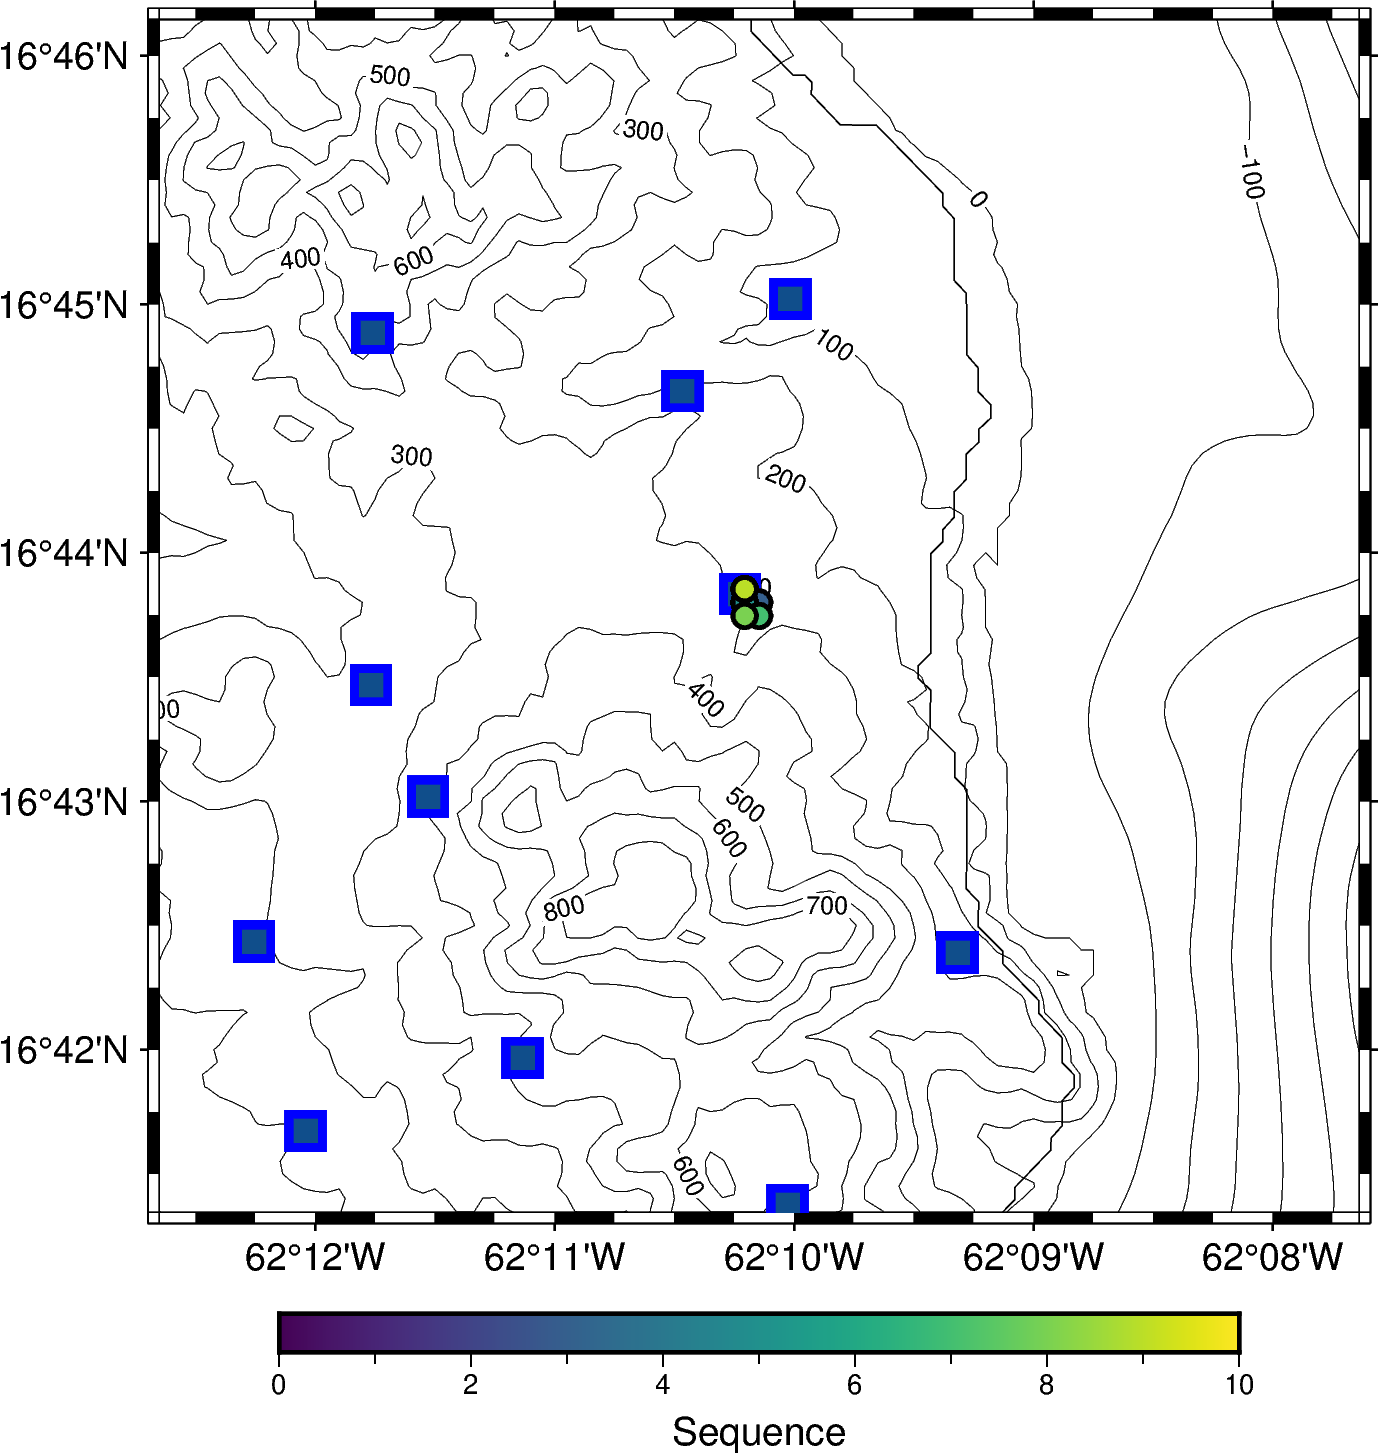

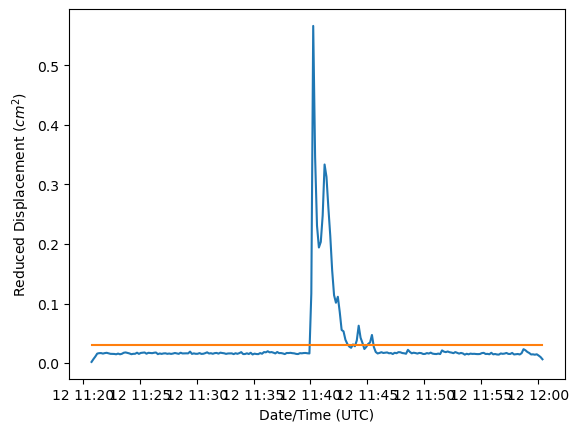

In [11]:
import os
import sys
import numpy as np
import time
import obspy
from obspy import read_inventory
sys.path.append('../lib')
import setup_paths
paths = setup_paths.paths
from SAM import DSAM
from ASL import montserrat_topo_map, Grid, ASL, simulate_DSAM
import pipelines

# same parameters as before
Q = 23
surfaceWaveSpeed_kms = 1.5 # km/s
peakf = 8.0

# same grid as before
source = {'lat':16.71111, 'lon':-62.17722}
#node_spacing_m = 20
node_spacing_m = 100
grid_size_lat_m = 10000
grid_size_lon_m = 8000
nlat = int(grid_size_lat_m/node_spacing_m) + 1
nlon = int(grid_size_lon_m/node_spacing_m) + 1
gridobj = Grid(source['lat'], source['lon'], nlat, nlon, node_spacing_m)  

# Load the waveform data & fix Montserrat Trace IDs
st1 = obspy.read('/shares/hal9000/share/data/SEISAN_DB/WAV/DSNC_/1999/08/1999-08-12-1120-46S.MVO___019', format='seisan')
st2 = obspy.read('/shares/hal9000/share/data/SEISAN_DB/WAV/DSNC_/1999/08/1999-08-12-1140-46S.MVO___019', format='seisan')
st = st1 + st2
pipelines.fix_montserrat_seed_ids(st)
st.merge(method=0, fill_value=0)
st = st.select(component='Z')
#st.plot(equal_scale=False);

# Load inventory
invMVO = read_inventory(os.path.join(paths['RESPONSE_DIR'],'MV.xml'), format='stationxml')

# drop bad traces. MBGH has no signal, MBMH is noisy. 
for tr in st.select(station="MBGH"):
    st.remove(tr) 
for tr in st.select(station="MBMH"):
    st.remove(tr)     

# remove instrument response - and set units accordingly IMPORTANT!
pre_filt = [0.4, 0.5, 18, 20]
#pre_filt = [6.0, 7.0, 9.0, 10.0]
st.remove_response(inventory=invMVO, pre_filt=pre_filt, output="DISP", plot=False) 
for tr in st:
    tr.stats['units'] = 'm'
#st.plot(equal_scale=True);

# compute DSAM data with 10-s time window
for tr in st:
    tr.stats['units'] = 'm'
dsamObj = DSAM(stream=st, sampling_interval=10)
#print(dsamObj)
#dsamObj.plot(metrics='rms', equal_scale=True)

source1 = {'lat':16.71111, 'lon':-62.17722}
DRSobj = dsamObj.compute_reduced_displacement(invMVO, source1, surfaceWaves=True, Q=None, wavespeed_kms=1.5)

DRSmaxrms = DRSobj.max(metric='VT')
print(f'Maximum DRS assuming fixed source is: {DRSmaxrms}')
#DRSobj.plot(equal_scale=True)

aslobj = ASL(dsamObj, 'VT', invMVO, gridobj)

aslobj.compute_grid_distances()

aslobj.compute_amplitude_corrections(surfaceWaves=True, wavespeed_kms=surfaceWaveSpeed_kms, Q=None, fix_peakf = peakf)

source_pf = aslobj.fast_locate()

aslobj.plot(source_pf, zoom_level=1, threshold_DR=0.03, scale=0.2, join=True, number=10, equal_size=True, add_labels=False)

-62.17954256048537 -62.158658680362706 16.719096432118285 16.739096432118288


/home/thompsong/miniconda3/envs/pygmt_python311_obspy/lib/python3.11/site-packages/obspy/core/inventory/network.py:321: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)
/superfast2TB/home2/thompsong/Developer/MESS2024_Glenn/src/30_ASL/../lib/ASL.py:379: FutureWarning: The 'color' parameter has been deprecated since v0.8.0 and will be removed in v0.12.0. Please use 'fill' instead.
  fig.plot(x=x, y=y, size=symsize, style="cc", pen='1p,black', color=timecolor, cmap=True)


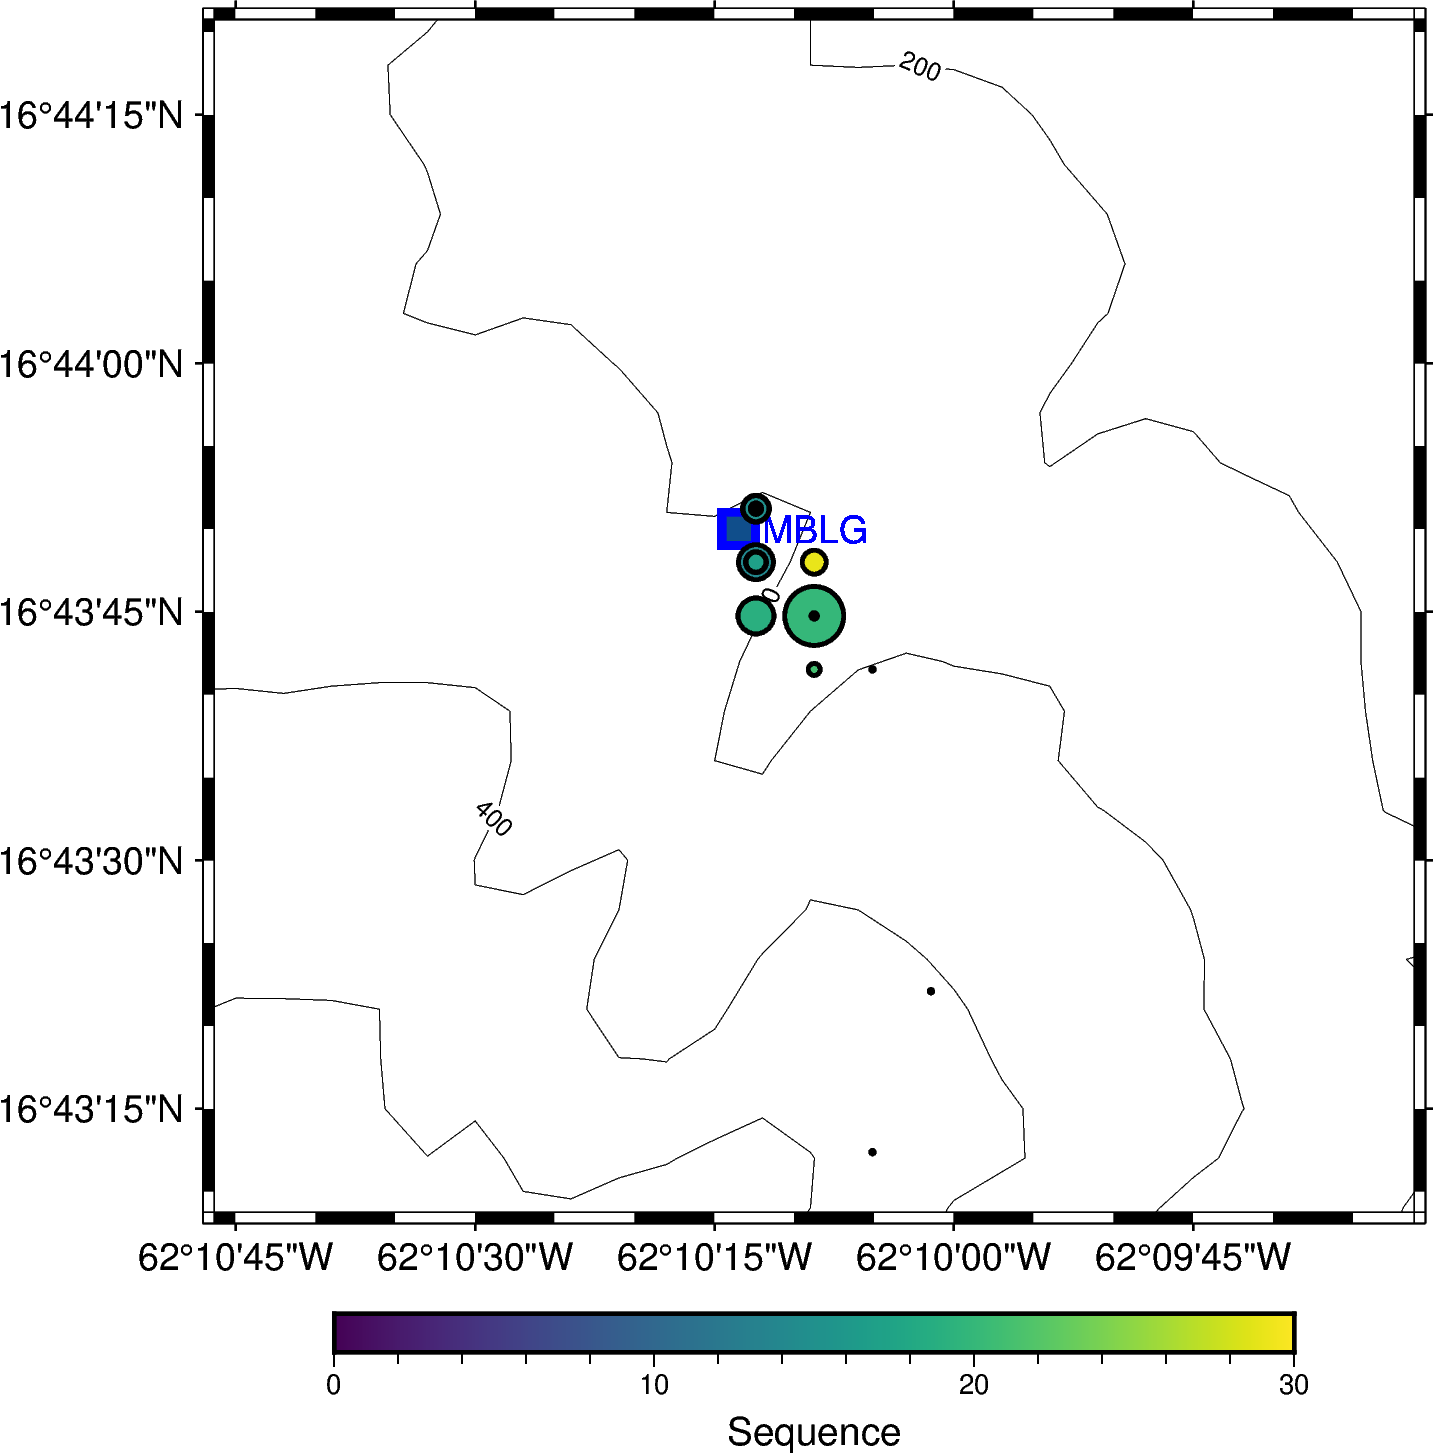

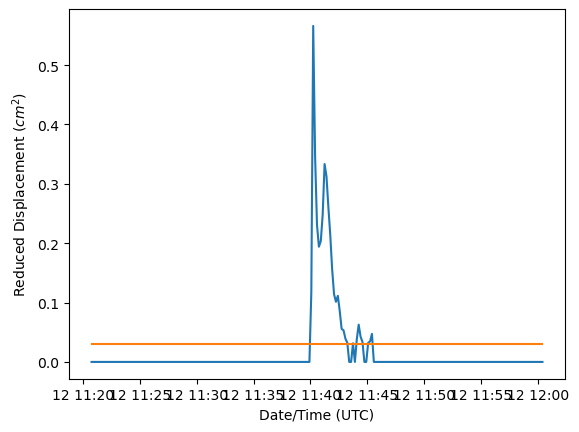

In [12]:
aslobj.plot(source_pf, zoom_level=3, threshold_DR=0.03, scale=0.5, join=True, number=30, add_labels=False)

## 5. Summary

I call the approach above "naive" ASL, because for simplicity (and speed, for real-time application) it ignores the vertical dimension, and assumes a homogeneous, isotropic half space (1-layer). It also considers the seismic source to be a point source, and assumes only one event is occurring at a time. In reality, pyroclastic flows cause multiple seismic sources per unit time, over an extended area, and this evolves with time as the flow moves downhill. Moreover, there can be numerous pyroclastic flows travelling down different flanks of the volcano at the same time, such as in a major dome collapse which may be comprised of dozens of pyroclastic flows that reach the coast. The average location determined by ASL is likely the top of the dome. 